# Présentation du problème

Nous avons des données d'Hydro-Québec sur la consommation d'électricité. Nous aimerions être capable de prédire notre consommation en fonction de la température comme l'hivers approche.

Dans cet exercice, nous allons apprendre les bases de l'apprentissage automatique. Nous supposons que vous n'avez aucune conaissance en apprentissage automatique, mais que vous avez les bases en Python. Nous avons allons utiliser la librairie pandas pour les données, mais vous pouvez aussi faire les exercices en numpy.

Pour réaliser l'exercice, nous allons utiliser les données de consommation d'électricité obtenues à la fin de la séance d'exercice en pandas. Par contre, vous n'avez pas à avoir assisté à la séance pour faire cette séance d'exercice.

Donc nous allons lire les données et les mettre sous la forme d'un DataFrame.

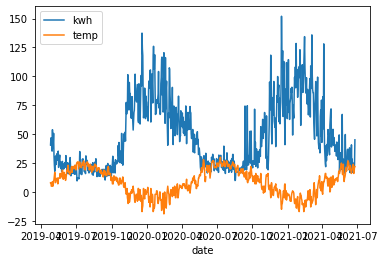

In [ ]:
import pandas as pd


# convert kwh
def str2float(value):
    new_value = value
    if type(value) == str:
        # change , into .
        new_value = value.replace(',', '.')
        # cast to float
        new_value = float(new_value)
    return new_value

# convert date
def str2date(value):
    new_value = value
    if type(value) == str:
        # via builtin converters de pandas...
        new_value = pd.to_datetime(value).date()
    return new_value

# data import
def load_jour(file_path, alt_encoding='latin-1', sep=';'):
    """
    Traiter un fichier de données journalières provenant de Hydro-Québec.
    """

    # load
    try:
        # UTF-8
        data = pd.read_csv(file_path, sep=sep)
    except UnicodeDecodeError:
        # alt_encoding
        data = pd.read_csv(file_path, encoding=alt_encoding, sep=sep)

    # rename columns
    columns = {
        'Contrat': 'contrat',
        'Tarif': 'tarif',
        'Date': 'date',
        'kWh': 'kwh',
        'Code de consommation': 'consommation',
        'Température moyenne (°C)': 'temp',
        'Code de température': 'temp_code',
    }
    data = data.rename(columns=columns)

    # convert kwh values
    data.loc[:, 'kwh'] = data['kwh'].apply(str2float)

    # convert date values
    data.loc[:, 'date'] = data['date'].apply(str2date)

    # keep useful columns
    data = data[['date', 'kwh', 'temp']]

    # new index for rows
    data.set_index('date', inplace=True)

    return data

# https://github.com/mtlpy/mtlpy-exercises/tree/main/hydro/data/jours
main_url = 'https://raw.githubusercontent.com/mtlpy/mtlpy-exercises/main/hydro/data/jours'

file_urls = [
    # seulement jours continus pour éviter trous dans graph
    # f'{main_url}/0123456789_jour_2018-06-19_au_2018-08-20.csv',
    f'{main_url}/0123456789_jour_2019-04-25_au_2019-06-25.csv',
    f'{main_url}/0123456789_jour_2019-06-26_au_2019-08-23.csv',
    f'{main_url}/0123456789_jour_2019-08-24_au_2019-10-24.csv',
    f'{main_url}/0123456789_jour_2019-10-25_au_2019-12-20.csv',
    f'{main_url}/0123456789_jour_2019-12-21_au_2020-02-25.csv',
    f'{main_url}/0123456789_jour_2020-02-26_au_2020-04-27.csv',
    f'{main_url}/0123456789_jour_2020-02-26_au_2020-04-27.csv',
    f'{main_url}/0123456789_jour_2020-04-28_au_2020-06-25.csv',
    # f'{main_url}/0123456789_jour_2020-06-26_au_2020-07-05.csv',
    f'{main_url}/0123456789_jour_2020-06-26_au_2020-08-25.csv',
    f'{main_url}/0123456789_jour_2020-08-26_au_2020-10-26.csv',
    f'{main_url}/0123456789_jour_2020-10-27_au_2020-12-23.csv',
    f'{main_url}/0123456789_jour_2020-12-24_au_2021-02-23.csv',
    f'{main_url}/0123456789_jour_2021-02-24_au_2021-04-27.csv',
    # f'{main_url}/0123456789_jour_2021-04-28_au_2021-05-09.csv',
    f'{main_url}/0123456789_jour_2021-04-28_au_2021-06-25.csv',
]

# load csv files as dataframes
frames = []
for file_url in file_urls:
    data = load_jour(file_url)
    frames.append(data)

# merge in one dataset
jours = pd.concat(frames)
jours.sort_index(inplace=True)

# data visualization
jours.plot()

On peut voir qu'il y a une corrélation entre la température et la consommation d'électricité. Cela semble naturel. Si nous avons une corrélation entre deux variables c'est généralement un bon signe que l'on peut au moins en partie prédire une variable à partir de l'autre.

Cela tombe bien, nous aimerions savoir la consommation d'électricité en fonction de la température. Donc on va construire un modèle d'apprentissage automatique simple qui nous prédira la consommation en fonction de la température.

Une première étape dans un problème d'apprentissage automatique consiste à regarder les données. 

Question : Est-ce que vous pouvez faire un graphique de la consommation d'électricité en fonction de la température?

In [ ]:
list(jours)

['kwh', 'temp']

Text(0, 0.5, "consomation d'électricité (kwh)")

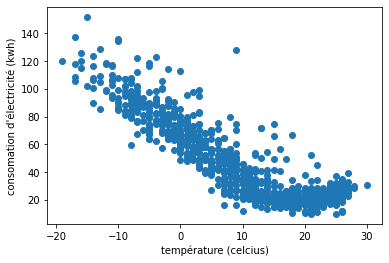

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(jours['temp'], jours['kwh'])
plt.xlabel('température (celcius)')
plt.ylabel('consomation d\'électricité (kwh)')

Question : combien de points de données nous avons ?

On peut voir qu'il y a une dépendance très claire entre température et consommation d'électricité.

La prochaine étape consiste à nettoyer un peu les données. 

Question : Regarder s'il y a des données manquantes dans notre set de données.

In [ ]:
jours.isnull().sum()

kwh     0
temp    1
dtype: int64

In [ ]:
jours.dropna(inplace=True)

In [ ]:
jours.isnull().sum()

kwh     0
temp    0
dtype: int64

Nous avons une donnée qui manque pour la température. Nous ne pouvons pas laisser les données ainsi, car le programme ne va pas savoir comment gérer cette situation.

Il y a différentes solutions pour régler le problème de données manquantes en apprentissage automatique.

1. simplement enlever ces données
2. remplacer la données par une valeur

    * par la moyenne ou médiane de la variable
    * lorsque nous avons des données qui varient dans le temps (comme c'est le cas ici), on peut prendre la moyenne de la donnée avant et de la donnée après
    * une valeur déterminée par un modèle simple en fonction des autres variables

Nous allons vous demander de faire la chose la plus simple, enlever la donnée.

Question : Enlever la donnée manquante du DataFrame

Généralement, ce que l'on fait lorsque l'on fait un projet d'apprentissage automatique, nous séparons les données en deux parties (ou trois, comme nous le verrons plus loin). 

Une partie qui sert à ce que l'algorithme apprend, que l'on appelle l'ensemble d'entrainement. Et l'autre, qui sert à tester l'algorithme. 

Il y a plusieurs manières de séparer ces données.

1. prendre chacune des données et les mettre aléatoirement soit pour l'entrainement, soit pour le test.
2. en fonction du temps. Séparer en fonction du temps peut faire du sens, car la situation peut changer, mais tu ne le sais pas d'avance. 

Par exemple, on pourrait avoir un problème de fenêtre qui devient mal isolée et accroit la facture d'électricité. Si on met ces données de la nouvelle année où la fenêtre est mal isolée dans nos données d'entrainement, notre modèle pourrait s'adapter à cette situation, mais dans la vraie vie, ton modèle ne voit pas le futur. C'est une forme de "fuite de données" (i.e. _data leakage_).

Comme nos données sont séparées dans le temps, on va séparer nos données en fonction du temps. On va mettre toutes les données de 2019 dans l'entrainement et on va tester notre modèle sur le reste de nos données. Il est assez fréquent que les ensembles de données soient séparés à environ 80% dans l'entrainement, 10% de validation et 10% de test.

In [ ]:
import datetime

jours_entrainement = jours[[date<datetime.date(2020, 1, 1)for date in jours.index]]
jours_test = jours[[date>=datetime.date(2020, 1, 1)for date in jours.index]]

On peut regarder combien de données nous avons dans notre ensemble d'entrainement et dans celui de test.

In [ ]:
print(f'Nous avons {jours_entrainement.shape[0]} données d\'entrainement')
print(f'Nous avons {jours_test.shape[0]} données de test')

Nous avons 251 données d'entrainement
Nous avons 603 données de test


On peut déjà faire un modèle de machine learning qui va prédire la consommation d'électricité en fonction de la température.

Nous allons utiliser le modèle de KNN pour faire cette prédiction. Ce n'est pas très important le modèle utilisé pour l'instant. C'est juste pour vous montrer comment utiliser la librairie scikit-learn.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=2)

Question : Est-ce que vous pouvez entrainer le modèle et dessiner les prédictions et les vraies valeurs sur un même graphique pour bien voir la différence?

In [ ]:
pd.get_dummies(jours['weekday'])

KeyError: ignored

Question : Est-ce que vous pouvez tester la prédiction sur les données de test et les afficher aussi sur un graphique.

On peut calculer différentes métriques qui permettent de donner une valeur numérique à quel point le modèle est correct.

Question : Calculer pour l'ensemble d'entrainement et celui de test, la métrique carré de l'erreur moyen

On voit que l'ensemble de test performe moins bien que celui d'entrainement. C'est généralement le cas dans des problèmes d'apprentissage automatique.

Nous avons dans nos données d'autres informations qui sont présentes. Nous avons par exemple la date. Ceci peut nous donner des informations intéressantes comme le jour de la semaine, le mois ou même l'année.

In [ ]:
jours['weekday'] = [x.weekday() for x in jours.index]
jours['month'] = [x.month for x in jours.index]
jours['year'] = [x.year for x in jours.index]

On peut voir que les journées de la semaine ne consomment pas la même quantité d'électricité.

0 - lundi

1 - mardi

2 - mercredi

...

6 - dimanche

In [ ]:
jours.groupby('weekday').mean()

,kwh,temp,month,year
weekday,,,,
0,47.487049,8.483607,6.237705,2019.909836
1,50.019752,8.685950,6.289256,2019.909091
2,48.512066,8.454545,6.198347,2019.917355
3,45.875610,8.325203,6.203252,2019.910569
4,50.897805,8.243902,6.130081,2019.918699
5,50.783770,7.836066,6.163934,2019.909836
6,50.305902,8.213115,6.204918,2019.909836


On peut utiliser cette information pour que le modèle d'apprentissage automatique apprenne aussi à partir de la journée de la semaine.

Par contre, contrairement à la température, le jour de la semaine n'est pas une variable qui fait du sens du point de vue numérique. Dimanche n'est pas nécessairement plus grand que lundi. Ce sont des catégories.

C'est pour cette raison que l'on apppelle ce type de variable des variables catégoriques. 

Pour les traiter à l'aide d'un modèle d'apprentissage automatique, on les transforme à l'aide de la méthode dite _one-hot encoding_ qui coniste à représenter cela à l'aide d'un vecteur dont la dimension est le nombre de catégorie. La valeur des éléments du vecteur sont 0 ou 1 dépendant si cela correspond à la classe.

Par exemple,

lundi -> (1, 0, 0, 0, 0, 0, 0)

mardi -> (0, 1, 0, 0, 0, 0, 0)

...

Question : Transformer la colonne jours de la semaine en 7 colonnes de _one-hot encoding_.

Question : Recréer des DataFrame d'entrainement et de test qui contiennent la température et les journées de la semaine en format _one-hot encoding_. Ensuite, retransformer en ensemble d'entrainement et de test.

Question : Entrainer un nouveau modèle de KNN avec ces nouvelles données et tester les résultats.

Comme on peut voir, il n'y a pas grand changement (et même un peu pire) dans les résultats que l'on vient de voir. Un problème est que KNN regarde les points plus proches pour faire la prédiction. Or la température en Celcius et le jour de la semaine prend des valeurs de 0 ou 1, alors l'effet du jour de la semaine est négligable. 

C'est pour cette raison qu'il est généralement une bonne pratique pour les variables numériques comme la température de les centrer autour d'une valeur de 0 et de les mettre dans l'ordre de valeur de 1 (qui seront alors dans le même ordre de grandeur que nos valeurs pour les jours de la semaine).

Question : Utiliser standard scaler de scikit-learn pour transformer la température et refaire toutes les étapes pour obtenir les prédictions sur l'ensemble de test et d'entrainement. (p.s. n'oublier pas de spécifier votre scaler à l'aide des données d'entrainement seulement, car les données de test sont à priori non disponibles lorsque vous utilisez votre modèle)

Le résultat est moins bon... est-ce que l'on garde ou pas? On aurait tendance à ne pas garder ce modèle et de garder le plus simple puisqu'il donne de meilleurs résultats.

# Données extrêmes

Par contre, on observe qu'il semble avoir plus de données aberrantes dans nos données de test que dans nos données d'entrainement. Il est certain que notre modèle est moins bon dans ce contexte.

Une question qui peut se poser est est-ce que l'on souhaite malgré tout vouloir définir la qualité de notre modèle avec ces cas extrêmes ou pas. Cela va dépendre du problème, mais regardons pour voir les résultats si nous n'avons pas ces cas extrêmes.

Question : À partir des données de votre dernière expérience, est-ce que vous pouvez enlever les données avec plus de 120 kwh et retester le modèle?


On voit que notre erreur de test est plus basse, mais cela ne veut rien dire parce nous avons enlevé des cas très difficiles. Pour dire si notre modèle présent est bon, il faut comparer à nos anciens modèles avec les données de test.

Question : Est-ce que vous pouvez retester sur le modèle de base sans les journées, mais toujours en enlevant les cas avec plus de 120 kwh?

La conclusion semble encore la même, c'est à dire qu'il est préférable de ne pas rajouter les journées de la semaine.


# Entrainer avec plus de données


Nous avons entrainé notre modèle avec une fraction de nos données. Regardons si on décide de prendre une fraction plus importante de données. En apprentissage automatique, avoir plus de données aide souvent les modèles.

Question : Recalculer le modèle KNN mais avec des données de 2018 et 2019 pour l'entrainement.

Nos résultats sont moins bons, mais il faut faire aussi attention, car on voit que la proportion de données aberrantes semble plus élevée et cela peut expliquer que notre erreur soit plus élevée.

Le point dans un projet d'apprentissage automatique c'est de pas sauter aux conclusions et essayer de comprendre vos données et vos résultats et de ne pas les évaluer de manière aveugle. Il faut toujours regarder dans un contexte.

# Recherche de paramètres

Nous avons utilisé le modèle KNN avec un certain nombre de voisins, mais on ne sait pas si c'est la valeur optimale. Dans ce cas ce que nous faisons c'est que l'on teste avec plusieurs valeurs et on retient celle qui est la meilleure. 

Généralement, pour ce faire on sépare nos données en trois partie : celle d'entrainement, celle de validation et celle de test.

Celles de validation sont nouvelles pour nous. On entraine encore avec l'ensemble de données d'entrainement comme on le faisait précédament. Ensuite, on choisit les meilleurs paramètres avec ceux qui donnent les meilleurs résultats sur l'ensemble de validation. On peut ensuite tester sur l'ensemble de test.

Pour tester ces différents paramètres, on peut utiliser différentes fonction de la librairie scikit-learn. Nous allons utiliser le "`grid_search`", qui teste toutes les possibilitées que nous lui donnons. De plus, la fonction prend en compte de tester sur un ensemble de validation qui est pris comme un sous ensemble des données d'entrainement (en pratique ce n'est pas exactement cela, cela utilise la technique de "_cross validation_"). Donc nous n'avons pas à nous préoccuper de cette partie.

Question : Utiliser la fonction `grid_search` de scikit-learn pour tester quel est le nombre de voisins optimal pour notre modèle parmi les valeurs 1, 2, 3, 4 et 5. Ensuite, entrainer avec le meilleur modèle sur vos données et tester si les résultats sont meilleurs sur notre ensemble de test.

Question : Vous pouvez essayer de prendre d'autres valeurs pour les voisins ou d'autres variables du modèle pour tester lequel est le meilleur sur le test.

# Extra Facebook prophet

On peut aussi utiliser des séries temporelles pour prédire dans le temps la consommation d'électricité. 

Facebook prophet est une librairie qui permet de faire des séries temporelles de manière assez simple.

In [ ]:
# en premier, il faut installer la librairie
!pip install pystan==2.19.1.1
!pip install prophet

In [ ]:
from fbprophet import Prophet


Question : Est-ce vous pouvez faire un modèle avec Prophet qui puisse prédire la consommation d'électricité en fonction du temps (pas de la température). Pour simplifier, utiliser toutes les données que nous avons et prédire pour un an la consommation d'électricité en fonction des jours.

# Licence

Copyright 2021 Montréal-Python

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
